In [4]:
import sys
sys.path.append('..')
import os
from os.path import join
import numpy as np
import pandas as pd
import connattractor.network as network
import connattractor.analysis as analysis
from sklearn.preprocessing import StandardScaler

import pickle

import seaborn as sns
sns.set_style("whitegrid")

In [9]:
# load embedding
with open('../data_out/default_hopfield_embedding_0.37.pkl', 'rb') as file:
    hopfield_embedding = pickle.load(file)
    
# load resting state data
_fd_thr = 0.15
_perc_scrub_thr = 0.5

# load data
from glob import glob
all_ts = []
root_dir = '../data_in/ex_timeseries/'
for f in glob(root_dir + 'bochum-???.tsv'):
    path, filename = os.path.split(f)
    ts = pd.read_csv(f, sep='\t').iloc[:, 1:].values
    ts = StandardScaler().fit_transform(ts)
    fd = pd.read_csv(path + '/FD_' + os.path.splitext(filename)[0] + '.txt', sep=',').values.flatten()
    fd = np.hstack(([0], fd))

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        all_ts.append(ts[fd<_fd_thr])
    else:
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))

#all_ts = np.vstack([i for i in all_ts])

/home/renglert/PycharmProjects/connattractor/venv/lib/python3.8/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/renglert/PycharmProjects/connattractor/venv/lib/python3.8/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


perc. scrubbed: 0.515


In [30]:
connfile = '../data_in/ex_connectome_partial_correlation.csv'
mtx = pd.read_csv(connfile).iloc[:, 1:]

hopnet = network.Hopfield(mtx, scale=True)
hopnet.beta = 0.045

### Hopnet relaxation

In [105]:
all_trajectories = []

iters = 1000
stepsize = 1
for j in range(len(all_ts[0])):
    ts = all_ts[0][j,:]
    state = ts.copy()
    trajectory = ts.copy()
    for i in range(iters-1):
        state, n_iter, energy = hopnet.update(state, num_iter=stepsize)
        trajectory = np.vstack([trajectory, state])
    all_trajectories.append(trajectory)

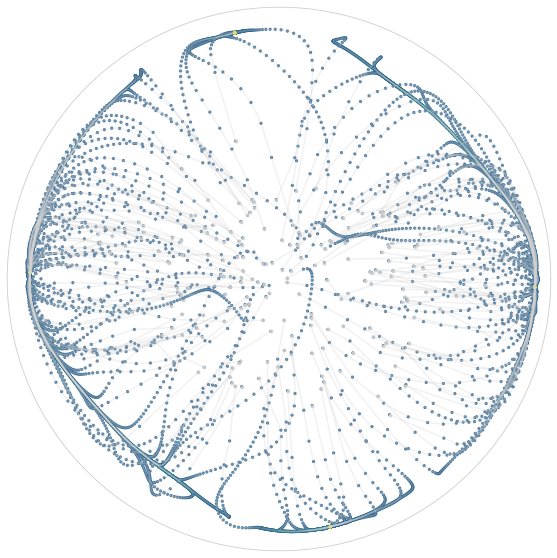

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a list of trajectories called "all_trajectories"
# Each trajectory is a 2D array, and you want to plot them on a polar plot

# Create a color map with enough colors for your trajectories
cmap = plt.get_cmap('viridis')  # You can choose a different colormap

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})

for i, trajectory in enumerate(all_trajectories):
    trajectory = StandardScaler().fit_transform(np.array(trajectory).T).T
    trajectory_embedded = hopfield_embedding.embedding_model.transform(trajectory)
    r, th = analysis._cart2pol(trajectory_embedded[:, 0], trajectory_embedded[:, 1])
    
    # Assign a color to this trajectory based on the colormap
    #color = cmap(i / len(all_trajectories))  # Vary color based on position in the list
    color = [cmap(x/10) for x in np.logspace(0.5, 1, len(trajectory))]
    alpha = [x for x in np.linspace(0.8, 0.2, len(trajectory))]
    #color = [t[:-1] for t in color]
    # Plot the trajectory as a single line
    plt.plot(th, r, 'lightgray', alpha=0.3)
    ax.scatter(th, r, color=color, s=5, alpha=alpha)  # Adjust alpha if needed
    ax.scatter(th[0], r[0], color='lightgray', s=8, alpha=0.8)

ax.set_yticks([])
ax.set_xticks([])
ax.grid(False)

plt.show()


### Trajectory of timeseries in hopfield projection

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a color map with enough colors for your trajectories
cmap = plt.get_cmap('viridis')  # You can choose a different colormap

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})

for i, trajectory in enumerate(ts_ctr[:1]):
    trajectory = StandardScaler().fit_transform(np.array(trajectory).T).T
    trajectory_embedded = hopfield_embedding.embedding_model.transform(trajectory)
    r, th = analysis._cart2pol(trajectory_embedded[:, 0], trajectory_embedded[:, 1])
    
    # Assign a color to this trajectory based on the colormap
    color = cmap(i / len(ts_ctr))  # Vary color based on position in the list
    
    # Vary alpha levels for each point in the trajectory
    alpha_values = np.linspace(0.2, 1, len(trajectory))
    
    ax.plot(th, r, color=color)#, alpha=alpha_values)

ax.set_yticks([])
ax.set_xticks([])
ax.grid(False)

plt.show()


### Trajectory of simulated data in hopfield projection

In [ ]:
from sklearn.preprocessing import StandardScaler

sample_size = 200

# Split the original data into a list of items
sim_data = [simresults_ctr.states[i:i + sample_size, :] 
            for i in range(0, simresults_ctr.states.shape[0], 
                           sample_size)]


# Create a color map with enough colors for your trajectories
cmap = plt.get_cmap('viridis')  # You can choose a different colormap

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})

for i, trajectory in enumerate(sim_data[:1]):
    trajectory = StandardScaler().fit_transform(np.array(trajectory).T).T
    trajectory_embedded = hopfield_embedding.embedding_model.transform(trajectory)
    r, th = analysis._cart2pol(trajectory_embedded[:, 0], trajectory_embedded[:, 1])
    
    # Assign a color to this trajectory based on the colormap
    color = cmap(i / len(ts_ctr))  # Vary color based on position in the list
    
    # Vary alpha levels for each point in the trajectory
    alpha_values = np.linspace(0.2, 1, len(trajectory))
    
    ax.plot(th, r, color=color)#, alpha=alpha_values)

ax.set_yticks([])
ax.set_xticks([])
ax.grid(False)

plt.show()
